In [1]:
# IMPORTANTE
# TODO: na validacao se acontecer uma presenca no meio eu tenho que contar como erro meu

# TODO: adicionar a validacao la de baixo
# TODO: tentar uma unica variaval para ruptura
# TODO: Gerar os indicadores para o mario poder validar.

# ranqueamento das lojas
# se tiver presenca e eu marquei pontos la em cima, poderia contar como erro.

# Historico
- Rede dupla e/ou com 100 neuronios: ruim. Nos primeiros passos o resultado fica razoavel, mas quando avanca piora.
- Rede unica com 10 neuronios: bom.

In [2]:
#https://machinelearningmastery.com/timedistributed-layer-for-long-short-term-memory-networks-in-python/
import sys 
import json
import numpy as np # linear algebra
import matplotlib.pyplot as plt # this is used for the plot the graph 
import math
import collections
import pandas as pd

## for Deep-learing:
import keras
import tensorflow as tf
from keras import backend as K
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import TimeDistributed
from keras.layers import Lambda
from keras.models import model_from_json
from tensorflow.python.keras.callbacks import TensorBoard

from itertools import product
from functools import partial
from time import time

from core.DataExploration import DataExploration
from ruptura.CreateBatch import CreateBatch
from ruptura.RupturaPrediction import RupturaPrediction
from ruptura.RupturaNeuralNetwork import RupturaNeuralNetwork

Using TensorFlow backend.


# CARREGAMENTO DOS DADOS

In [3]:
createBatch = CreateBatch()
amostras = createBatch.loadBatch('biscoitos-barbieri-1-3-19.json')
#X, Y, Ytest = createBatch.batch(amostras,nDiasTreino = 60, nDiasTeste = 10)

In [4]:
# BATCH DEFINITION
X = []
Y = []
Ytest = []
for key in amostras:
    x = np.array(amostras[key]['x'])
    y = np.array(amostras[key]['y'])
    yt = np.array(amostras[key]['ytest'])
    if x.shape != (60,4):
        continue
    X.append(x)
    Y.append(y)
    Ytest.append(yt)
X = np.array(X)
Y = np.array(Y)
Ytest = np.array(Ytest)

# MODEL DEFINITION

In [6]:
#DEFINE THE MODEL
batch_size = 64
time_steps = X.shape[1]
x_dimension = X.shape[2]
rupNN = RupturaNeuralNetwork()
newModel = False

if newModel:
    n_neurons = 15
    model = Sequential()
    model.add(LSTM(n_neurons, input_shape=(time_steps, x_dimension), return_sequences=True)) 
    model.add(TimeDistributed(Dense(x_dimension, activation='softmax')))
    #model.add(LSTM(n_neurons, input_shape=(time_steps, x_dimension), return_sequences=True)) 
    #model.add(TimeDistributed(Dense(x_dimension, activation='softmax')))
    model.compile(
        loss=rupNN.getCustomLoss((batch_size,time_steps)),
        #loss = 'categorical_crossentropy', 
        optimizer='adam')
    print('MODEL CREATED\n')
    print(model.summary())
else:
    model = rupNN.loadModel((batch_size,time_steps))  # Y dimensions are needed for custom loss definitions
    print('MODEL LOADED\n')
    print(model.summary())

MODEL LOADED

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60, 10)            600       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 60, 4)             44        
Total params: 644
Trainable params: 644
Non-trainable params: 0
_________________________________________________________________
None


# TRAINING

In [ ]:
cut1 = batch_size
cut2 = X.shape[0] - X.shape[0]%batch_size
Xval, Xtrain,_ = np.split(X,[cut1,cut2])
Yval, Ytrain,_ = np.split(Y,[cut1,cut2])

for step in range(30):
    n_epoch = 100
    model.fit(Xtrain, Ytrain, 
                  epochs=n_epoch, 
                  batch_size= batch_size, 
                  validation_data=(Xval, Yval),
                  verbose=2)
    rupNN.saveModel(model)

# VALIDATION

Contratos adimplentes:   1788
Contratos inadimlentes:  409
xAxis:   [0.0, 23.0, 46.0, 69.0, 92.0] 

yAxis:   [2, 18, 36, 73, 97] 



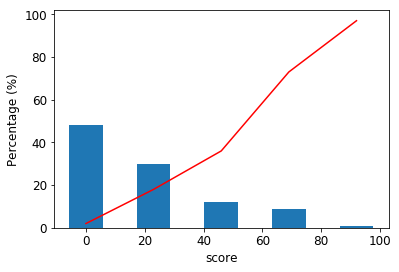

In [7]:
rupPred = RupturaPrediction(X)
rupPred.addFirstPrediction(Y)
rupPred.validate(Ytest, model)
dataScore = rupPred.calculateDataScore()  # passo muito importante para a validacao
rupPred.plotScore(dataScore)

In [16]:
dataScore.to_csv('score-rupt.csv',sep=';')

In [9]:
def getScoreEvolution(i_batch, scorePred, realValues):
    scoresI = []
    yI = []
    for i in range(scorePred.shape[0]):
        scoresI.append(scorePred[i][i_batch])
        yI.append(realValues[i][i_batch])
    return [scoresI,yI]   

In [11]:
rupPred = RupturaPrediction(X)
rupPred.addFirstPrediction(Y)
rupPred.validate(Ytest, model)
scorePred = rupPred.getScore()
realValues = rupPred.getRealValues()

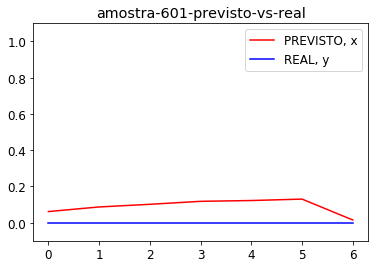

In [29]:
i_batch = 601
scPred, y = getScoreEvolution(i_batch, scorePred, realValues)
fig = plt.figure()
name = 'amostra-' + str(i_batch) + '-previsto-vs-real'
plt.title(name)
plt.ylim((-0.1, 1.1))  
plt.plot(range(len(scPred)), scPred, 'r', label='PREVISTO, x') # x
plt.plot(range(len(scPred)),y , 'b', label='REAL, y') # y
plt.legend(loc='best')
fig.savefig(name + '.png',dpi=150)
#plt.show()  